In [31]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing;
from sklearn.model_selection import cross_validate as cross_validation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# %matplotlib inline

In [32]:
import datetime
from datetime import timedelta
forecast_out = 365 #Days from now

stock_ticker ='BA'
stock_parameter ='Low'
epoch_number=100
epoch_number_forecast=100

end = datetime.datetime.now()#-timedelta(7) #remove timedetla -1 to go to productions mode
start = datetime.datetime.now()-timedelta(forecast_out)

# benchmark = web.DataReader(stock_ticker, 'yahoo', start, end )
stock = web.DataReader(stock_ticker, 'yahoo', start, end)


In [33]:
test_size=20
test_index = len(stock[stock_parameter])- test_size

In [34]:
train = stock[stock_parameter].iloc[:test_index]
test= stock[stock_parameter].iloc[test_index:]

In [35]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
scaler=MinMaxScaler()
scaler.fit(train.to_frame())
scaled_train = scaler.transform(train.to_frame())
scaled_test = scaler.transform(test.to_frame())

In [37]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [38]:
length=test_size-1
generator = TimeseriesGenerator(scaled_train,scaled_train, length=length, batch_size=1)

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [40]:
n_features =1
model= Sequential()
# pretty good model at 200 epochs
# model.add(LSTM(50, activation='relu', input_shape=(length, n_features)))
# model.add(Dropout(0.2))
# model.add(Dense(25, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(10, activation='relu'))
# model.add(Dropout(0.2))

model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(15, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [41]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=1)

In [42]:
validation_generator= TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size =1)

In [43]:
# model.fit_generator(generator, epochs=20,
#                    validation_data=validation_generator, callbacks=[early_stop])
model.fit_generator(generator, epochs=epoch_number,
                   validation_data=validation_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 212 steps, validate for 1 steps
Epoch 1/100
212/212 [==============================] - 3s 15ms/step - loss: 0.1288 - val_loss: 0.0313
Epoch 2/100
212/212 [==============================] - 2s 7ms/step - loss: 0.0540 - val_loss: 0.0152
Epoch 3/100
212/212 [==============================] - 2s 8ms/step - loss: 0.0341 - val_loss: 4.4343e-04
Epoch 4/100
212/212 [==============================] - 2s 7ms/step - loss: 0.0291 - val_loss: 6.5511e-04
Epoch 5/100
212/212 [==============================] - 2s 7ms/step - loss: 0.0243 - val_loss: 1.4986e-05
Epoch 6/100
212/212 [==============================] - 2s 7ms/step - loss: 0.0211 - val_loss: 5.3721e-04
Epoch 7/100
212/212 [==============================] - 2s 7ms/step - loss: 0.0205 - val_loss: 0.0021
Epoch 8/100
212/212 [==============================] - 2s 7ms/step - loss: 0.0200 - val_loss: 0.0206
Epoch 9/100
212/212 [==============================] - 2s 7ms/step - loss: 0.0195 -

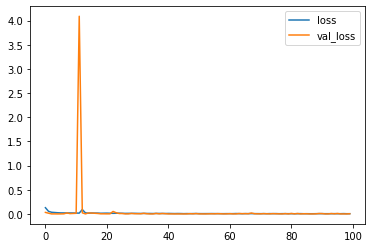

<Figure size 432x288 with 0 Axes>

In [44]:
losses= pd.DataFrame(model.history.history)
ax =losses.plot()
plt.show()
plt.savefig(stock_ticker+'_'+stock_parameter+'loss_chart.png')

In [45]:
test_predictions =[]
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))
for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    test_predictions.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [46]:
true_predictions =scaler.inverse_transform(test_predictions)


In [47]:
predictions = pd.DataFrame(test)
predictions['Predictions'] = true_predictions

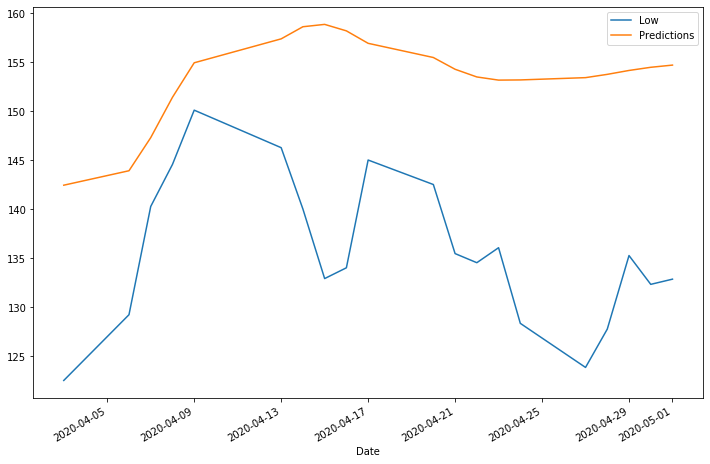

<Figure size 432x288 with 0 Axes>

In [48]:
ax=predictions.plot(figsize=(12,8))
plt.show()
plt.savefig(stock_ticker+'_'+stock_parameter+'predictions_chart.png')

In [49]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'prediction'+'.h5')

# Forecasting

In [50]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(stock[stock_parameter].to_frame())

In [51]:
length=19
generator=TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [52]:
forecast_model= Sequential()
forecast_model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(50, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(15, activation='relu'))
forecast_model.add(Dropout(0.2))
forecast_model.add(Dense(1, activation='relu'))
forecast_model.compile(optimizer='adam', loss='mse')
forecast_model.fit_generator(generator, epochs=epoch_number_forecast)

  ...
    to  
  ['...']
Train for 232 steps
Epoch 1/100
232/232 [==============================] - 3s 14ms/step - loss: 0.1655
Epoch 2/100
232/232 [==============================] - 2s 9ms/step - loss: 0.0576
Epoch 3/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0395
Epoch 4/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0344
Epoch 5/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0327
Epoch 6/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0224
Epoch 7/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0229
Epoch 8/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0184
Epoch 9/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0190
Epoch 10/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0175
Epoch 11/100
232/232 [==============================] - 2s 8ms/step - loss: 0.0162
Epoch 12/100
232/232 [============================

In [53]:
from keras.models import load_model
model.save(stock_ticker+'_'+stock_parameter+'forecast'+'.h5')

In [54]:
forecast =[]

periods=19

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [55]:
forecast = scaler.inverse_transform(forecast)

In [56]:
forecast

array([[151.10249428],
       [154.99199647],
       [157.55042567],
       [158.78936931],
       [158.85649049],
       [158.08274609],
       [156.90787984],
       [155.56140372],
       [154.38337965],
       [153.52461099],
       [153.05323646],
       [152.95581777],
       [153.13230472],
       [153.54897882],
       [154.03465126],
       [154.44707986],
       [154.74175692],
       [154.91112124],
       [154.93345403]])

In [57]:
from datetime import date
forecast_index = pd.date_range(start=date.today(), periods = periods, freq="D")

In [58]:
forecast_df = pd.DataFrame(data = forecast, index=forecast_index, columns=['Forecast'])

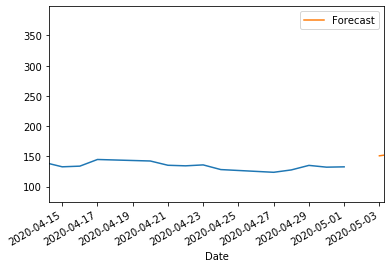

In [59]:
ax=stock[stock_parameter].plot()
forecast_df.plot(ax=ax)
plt.xlim( datetime.datetime.now()-timedelta(periods), datetime.datetime.now())
plt.savefig(stock_ticker+'_'+stock_parameter+'forecast_chart.png')


In [60]:
forecast_df.to_csv('forecast_'+stock_ticker+'_'+stock_parameter+'.csv')